In [1]:
from google.cloud import bigquery
#https://github.com/vinsburg/alluvial_diagram
import alluvial
from matplotlib import colormaps
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 as pg
import os
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.lines import Line2D
import upsetplot
from sankeyflow import Sankey
import sklearn

In [2]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=8) 
plt.rc('axes', titlesize=8) 
plt.rc('axes', labelsize=8) 
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
plt.rc('legend', fontsize=8)
%config InlineBackend.figure_format = 'retina'

In [4]:
host = os.environ['KB_HOST']
database = os.environ['KB_DATABASE']
user = os.environ['KB_USER']
pw = os.environ['KB_PASSWORD']
port = os.environ['KB_PORT']
engine = create_engine(f'postgresql://{user}:{pw}@{host}:{port}/{database}')

In [5]:
openalex_type_mapping = {
    'journal': {
        'editorial_discourse': ['erratum', 'editorial', 'letter', 'paratext'],
        'research_discourse': ['article', 'journal-article'],
        'others': ['grant', 'book-chapter', 'dataset', 'book', 'other', 'reference-entry', 'dissertation', 
                   'report', 'peer-review', 'standard', 'book-series']
    }
}

In [6]:
s2_type_mapping = {
    'journal': {
        'editorial_discourse': ['Editorial', 'News', 'LettersAndComments'],
        'research_discourse': ['Review', 'MetaAnalysis', 'JournalArticle', 'Study', 'CaseReport', 'ClinicalTrial'],
        'others': ['Conference', 'Book', 'Dataset']
    }
}

In [7]:
pubmed_type_mapping = {
    'journal': {
        'editorial_discourse': ['Published Erratum', 'Retraction of Publication', 'Retracted Publication', 'Editorial', 'News', 'Letter', 'Comment',
                                'Introductory Journal Article', 'Newspaper Article'],
        'research_discourse': ['Cochrane Systematic Review', 'Systematic Review', 'Meta-Analysis', 'Review', 'Case Reports', 'Randomized Controlled Trial', 
                               'Clinical Trial', 'Clinical Trial, Phase II', 'Clinical Trial, Phase III', 'Clinical Trial, Phase I', 
                               'Clinical Trial, Phase IV', 'Controlled Clinical Trial', 'Pragmatic Clinical Trial', 'Journal Article', 
                               'Comparative Study', 'Multicenter Study', 'Observational Study', 'Evaluation Study', 'Historical Article', 
                               'Validation Study', 'Clinical Study', 'Randomized Controlled Trial, Veterinary',
                               'Twin Study', 'Clinical Trial, Veterinary', 'Classical Article', 'Observational Study, Veterinary', 'Corrected and Republished Article', 
                               'Adaptive Clinical Trial', 'Evaluation Studies', 'Validation Studies', "Research Support, Non-U.S. Gov''t", "Research Support, N.I.H., Extramural", 
                               "Research Support, U.S. Gov''t, Non-P.H.S.", "Research Support, U.S. Gov''t, P.H.S.", 'Preprint',
                               "Research Support, N.I.H., Intramural", "Research Support, American Recovery and Reinvestment Act", 'Equivalence Trial'], 
        'others': ['English Abstract', 'Video-Audio Media', 'Biography', 'Practice Guideline', 'Portrait', 
                   'Congress', 'Clinical Trial Protocol', 'Interview', 'Personal Narrative', 'Consensus Development Conference', 'Overall', 
                   'Patient Education Handout', 'Guideline', 'Dataset', 'Lecture', 'Address', 'Clinical Conference', 'Expression of Concern', 
                   'Legal Case', 'Autobiography', 'Technical Report', 'Webcast', 'Bibliography', 'Festschrift', 'Consensus Development Conference, NIH', 
                   'Interactive Tutorial', 'Scientific Integrity Review', 'Duplicate Publication', 'Directory',  'Periodical Index', 'Dictionary', 'Legislation']
    }
}

In [8]:
scp_type_mapping = {
    'journal': {
        'editorial_discourse': ['Erratum', 'Editorial', 'Letter', 'Note'],
        'research_discourse': ['Review', 'Article'],
        'others': ['Conference Paper', 'Chapter', 'Short Survey', 'Book', 'Tombstone', 'Data Paper', 'Article in Press', 
                   'Conference Review', 'Abstract Report', 'Business Article', 'getItemType: unmatched: pp', 'Report']
    }
}

In [9]:
wos_type_mapping = {
    'journal': {
        'editorial_discourse': ['Correction', 'Retraction', 'Retracted Publication', 'Item Withdrawal', 'Editorial Material', 'News Item', 'Letter', 'Note'],
        'research_discourse': ['Review', 'Article'],
        'others': ['Meeting Abstract', 'Book Review', 'Early Access', 'Biographical-Item', 'Book Chapter', 'Poetry', 'Reprint', 'Data Paper', 
                   'Bibliography', 'Fiction, Creative Prose', 'Art Exhibit Review', 'Theater Review', 'Software Review', 'CC Meeting Heading', 
                   'Record Review', 'Expression of Concern', 'Film Review', 'Music Performance Review', 'Music Score Review', 'TV Review, Radio Review', 
                   'Excerpt', 'Database Review', 'Script', 'Hardware Review', 'Dance Performance Review', 'Book', 'Music Score', 
                   'Chronology', 'Meeting Summary', 'Main Cite', 'Meeting-Abstract', 'Proceedings Paper']
    }
}

In [10]:
def mapping_types(mapping_dict, type):
    for k, v in mapping_dict.items():
        if type in v:
            return k

In [16]:
def alluvial_plot(df, db1_column_name, db2_column_name, db1_name, db2_name, image_name, width, height, v_gap_frac=0.09):
    df.fillna('None', inplace=True)
    d = {}
    for row in df.to_dict('records'):
        db1_type = row[db1_column_name] + ' (' + db1_name + ')'
        db2_type = row[db2_column_name] + ' (' + db2_name + ')'
        n = row['n']
    
        dd = {}
        dd[db2_type] = n
        
        if db1_type in d:
            d[db1_type].update(dd)
        else:
            d[db1_type] = dd

    l = dict()
    for k, v in d.items():
        for k2, v2 in v.items():
            l[k2] = 0
        
    for k, v in d.items():
        for k2, v2 in v.items():
            l[k2] += v2

    d_plot = {k: dict() for k in d.keys()}
    for k, v in d.items():
        for k2, v2 in v.items():
            d_plot[k][f'{k2}\n{l[k2]:,}'] = v2
            
    d_plot = {f'{k}\n{sum(v.values()):,}': v for k, v in d_plot.items()}

    cmap = colormaps['gist_earth']

    ax = alluvial.plot(d_plot, alpha=0.4, cmap=cmap, v_gap_frac=v_gap_frac, color_side=0, fontname='Arial')
    fig = ax.get_figure()
    fig.set_size_inches(width, height)
    plt.show()
    fig.savefig(f'media/{image_name}.png', format='png', bbox_inches='tight', dpi=500)

In [12]:
def alluvial_plot_new_types(df, db1_column_name, db2_column_name, db1_name, db2_name, db1_mapping, db2_mapping, image_name, width, height, v_gap_frac=0.045):
    df2 = df.copy()
    df2['db1_new_type'] = df2.apply(lambda row : mapping_types(db1_mapping, row[db1_column_name]), axis=1)
    df2['db2_new_type'] = df2.apply(lambda row : mapping_types(db2_mapping, row[db2_column_name]), axis=1)
    df2.fillna('None', inplace=True)

    d = {}
    for row in df2.to_dict('records'):
        db1_type = row['db1_new_type'] + ' (' + db1_name + ')'
        db2_type = row['db2_new_type'] + ' (' + db2_name + ')'
        current_r = row['db1_new_type'] + ' (' + db1_name + ')'
        n = row['n']
    
        if current_r in d:
            if db2_type in d[db1_type].keys():
                d[db1_type][db2_type] = d.get(db1_type).get(db2_type) + n
            else:
                 d[db1_type][db2_type] = n
        else:
            dd = {}
            dd[db2_type] = n
            d[db1_type] = dd

    l = dict()
    for k, v in d.items():
        for k2, v2 in v.items():
            l[k2] = 0
        
    for k, v in d.items():
        for k2, v2 in v.items():
            l[k2] += v2

    d_plot = {k: dict() for k in d.keys()}
    for k, v in d.items():
        for k2, v2 in v.items():
            d_plot[k][f'{k2}\n{l[k2]:,}'] = v2
            
    d_plot = {f'{k}\n{sum(v.values()):,}': v for k, v in d_plot.items()}

    cmap = colormaps['gist_earth']

    ax = alluvial.plot(d_plot, alpha=0.4, colors=['#C82E6B', '#65BADA', '#E5BA52', '#D86F27'], v_gap_frac=v_gap_frac, fontname='Arial')
    fig = ax.get_figure()
    fig.set_size_inches(width, height)
    plt.show()
    fig.savefig(f'media/{image_name}.png', format='png', bbox_inches='tight', dpi=500)

In [47]:
oal_n = pd.read_sql("""
                    SELECT COUNT(DISTINCT(oal_works.doi)) AS n
                    FROM fiz_openalex_rep_20230819_openbib.works oal_works
                    WHERE oal_works.publication_year BETWEEN 2012 AND 2022
                    """, 
                    con=engine)

In [48]:
oal_n

,n
0,69456021


In [49]:
scp_n = pd.read_sql("""
                    SELECT COUNT(DISTINCT(scp_items.doi)) AS n
                    FROM scp_b_202307.items scp_items
                    WHERE scp_items.pubyear BETWEEN 2012 AND 2022
                    """, 
                    con=engine)

In [50]:
scp_n

,n
0,31922514


In [51]:
scp_oal_n = pd.read_sql("""
                        SELECT COUNT(DISTINCT(oal_works.doi)) AS n
                        FROM fiz_openalex_rep_20230819_openbib.works oal_works
                        JOIN scp_b_202307.items scp_items
                            ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(scp_items.doi)
                        WHERE oal_works.publication_year BETWEEN 2012 AND 2022
                        """, 
                        con=engine)

In [52]:
scp_oal_n

,n
0,30755337


In [53]:
wos_n = pd.read_sql("""
                    SELECT COUNT(DISTINCT(wos_items.doi)) AS n
                    FROM wos_b_202307.v_items wos_items
                    WHERE wos_items.pubyear BETWEEN 2012 AND 2022
                    """, 
                    con=engine)

In [54]:
wos_n

,n
0,23540852


In [55]:
wos_oal_n = pd.read_sql("""
                        SELECT COUNT(DISTINCT(oal_works.doi)) AS n
                        FROM fiz_openalex_rep_20230819_openbib.works oal_works
                        JOIN wos_b_202307.v_items wos_items
                            ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(wos_items.doi)
                        WHERE oal_works.publication_year BETWEEN 2012 AND 2022
                        """, 
                        con=engine)

In [56]:
wos_oal_n

,n
0,23211685


In [58]:
s2_n = pd.read_sql("""
                   SELECT COUNT(DISTINCT(s2_items.doi)) AS n
                   FROM unignhaupka.s2_2023_09_26_papers_2000 as s2_items
                   WHERE s2_items.year BETWEEN 2012 AND 2022
                   """, 
                   con=engine)

In [59]:
s2_n

,n
0,56279413


In [60]:
s2_oal_n = pd.read_sql("""
                       SELECT COUNT(DISTINCT(oal_works.doi)) AS n
                       FROM fiz_openalex_rep_20230819_openbib.works oal_works
                       JOIN unignhaupka.s2_2023_09_26_papers_2000 as s2_items
                           ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(s2_items.doi)
                       WHERE oal_works.publication_year BETWEEN 2012 AND 2022
                       """, 
                       con=engine)

In [61]:
s2_oal_n

,n
0,54448341


In [62]:
pm_n = pd.read_sql("""
                   SELECT COUNT(DISTINCT(pm_items.doi)) AS n
                   FROM dzhwaschniedermann.ac24_import_fromlocal AS pm_items
                   WHERE pubmed_date >= to_date('2012', 'YYYY') AND pubmed_date < to_date('2023', 'YYYY')
                   """, 
                   con=engine)

In [65]:
pm_n

,n
0,12681219


In [63]:
pm_oal_n = pd.read_sql("""
                       SELECT COUNT(DISTINCT(oal_works.doi)) AS n
                       FROM fiz_openalex_rep_20230819_openbib.works oal_works
                       JOIN dzhwaschniedermann.ac24_import_fromlocal AS pm_items
                           ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(pm_items.doi)
                       WHERE oal_works.publication_year BETWEEN 2012 AND 2022
                       """, 
                       con=engine)

In [64]:
pm_oal_n

,n
0,12594407


In [30]:
shared_n = pd.read_sql("""
                       SELECT COUNT(DISTINCT(shared_items.doi)) AS n
                       FROM unignhaupka.oal_wos_scp_s2_pubmed_comparison_2012_22 AS shared_items
                       """, 
                       con=engine)

In [31]:
shared_n

,n
0,9575603


In [20]:
oal_scp_venue = pd.read_sql("""
                         SELECT oal_sources.type AS oal_venuetype, scp_items.source_type AS scp_venuetype, COUNT(DISTINCT(oal_works.doi)) AS n
                         FROM fiz_openalex_rep_20230819_openbib.works oal_works
                         JOIN scp_b_202307.items scp_items
                             ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(scp_items.doi)
                         LEFT JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                             ON oal_works.id = oal_primary.work_id
                         LEFT JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                             ON oal_primary.source_id = oal_sources.id
                         WHERE oal_works.publication_year BETWEEN 2012 AND 2022
                         GROUP BY oal_venuetype, scp_venuetype
                         """, 
                         con=engine)

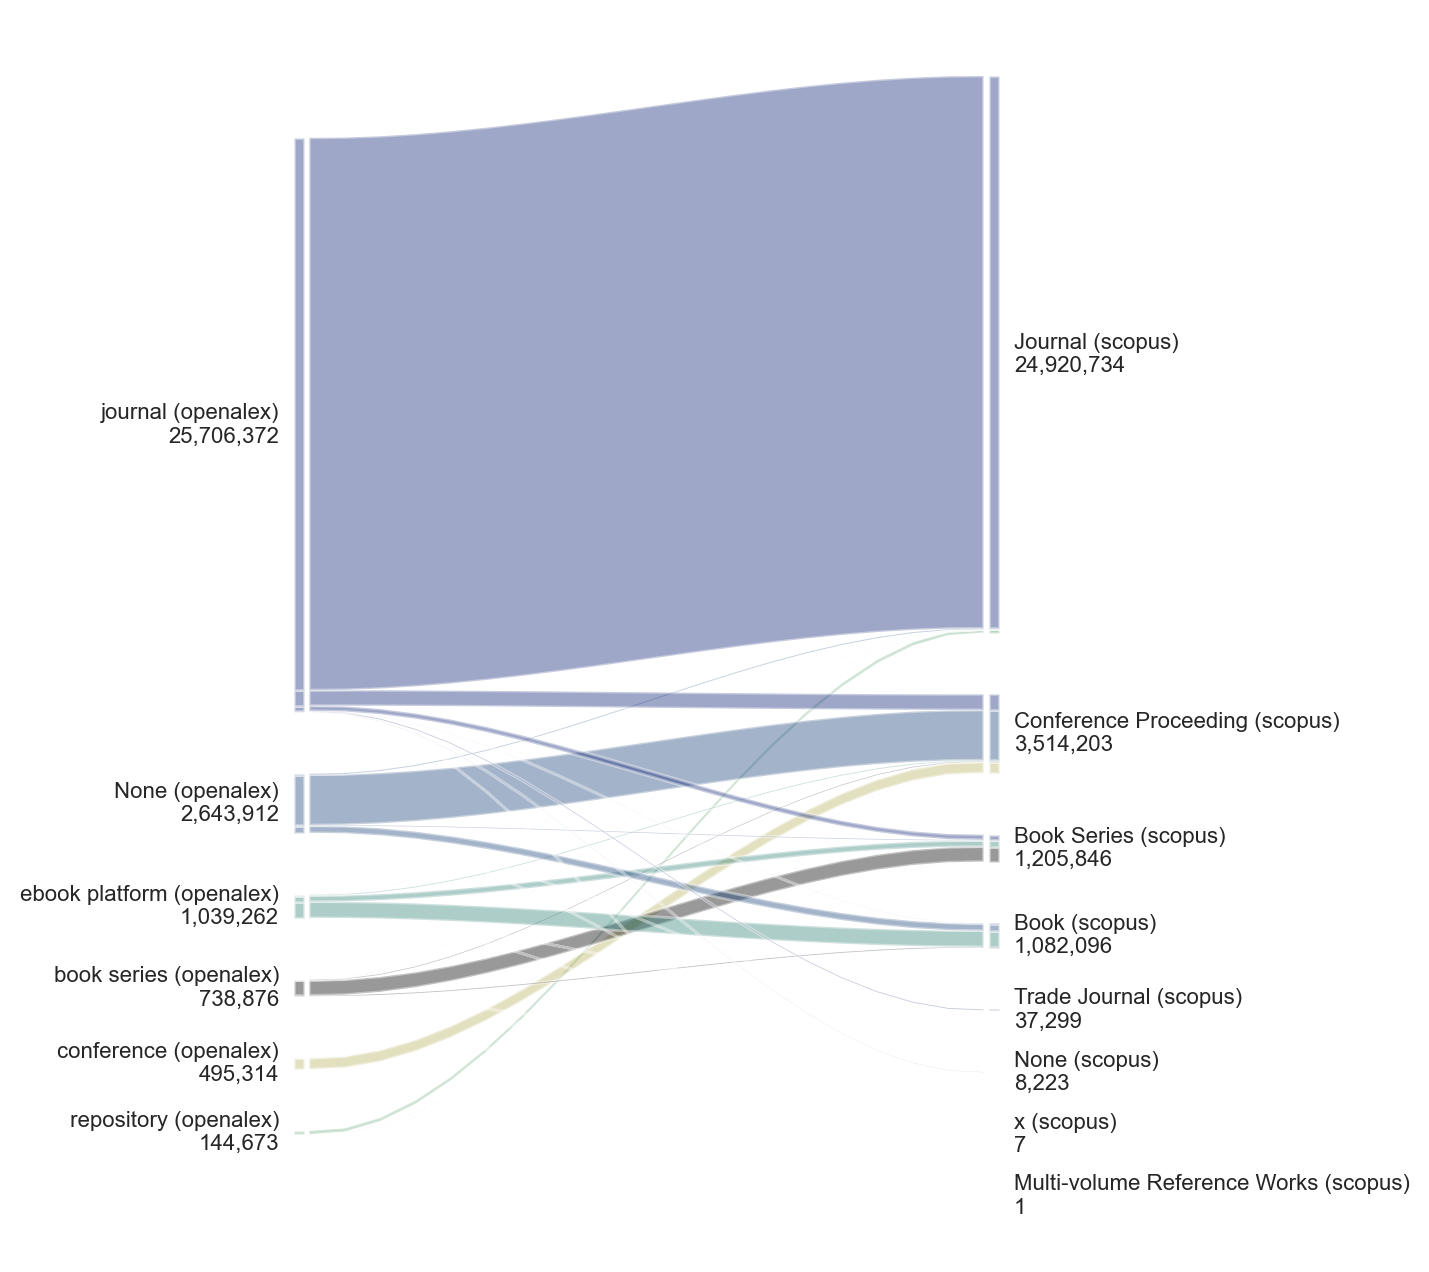

In [21]:
alluvial_plot(oal_scp_venue, 'oal_venuetype', 'scp_venuetype', 'openalex', 'scopus', 'openalex_scp_venues', 5, 8)

In [18]:
oal_wos_venue = pd.read_sql("""
                         SELECT oal_sources.type AS oal_venuetype, wos_items.source_type AS wos_venuetype, COUNT(DISTINCT(oal_works.doi)) AS n
                         FROM fiz_openalex_rep_20230819_openbib.works oal_works
                         JOIN wos_b_202307.v_items wos_items
                             ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(wos_items.doi)
                         LEFT JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                             ON oal_works.id = oal_primary.work_id
                         LEFT JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                             ON oal_primary.source_id = oal_sources.id
                         WHERE oal_works.publication_year BETWEEN 2012 AND 2022
                         GROUP BY oal_venuetype, wos_venuetype
                         """, 
                         con=engine)

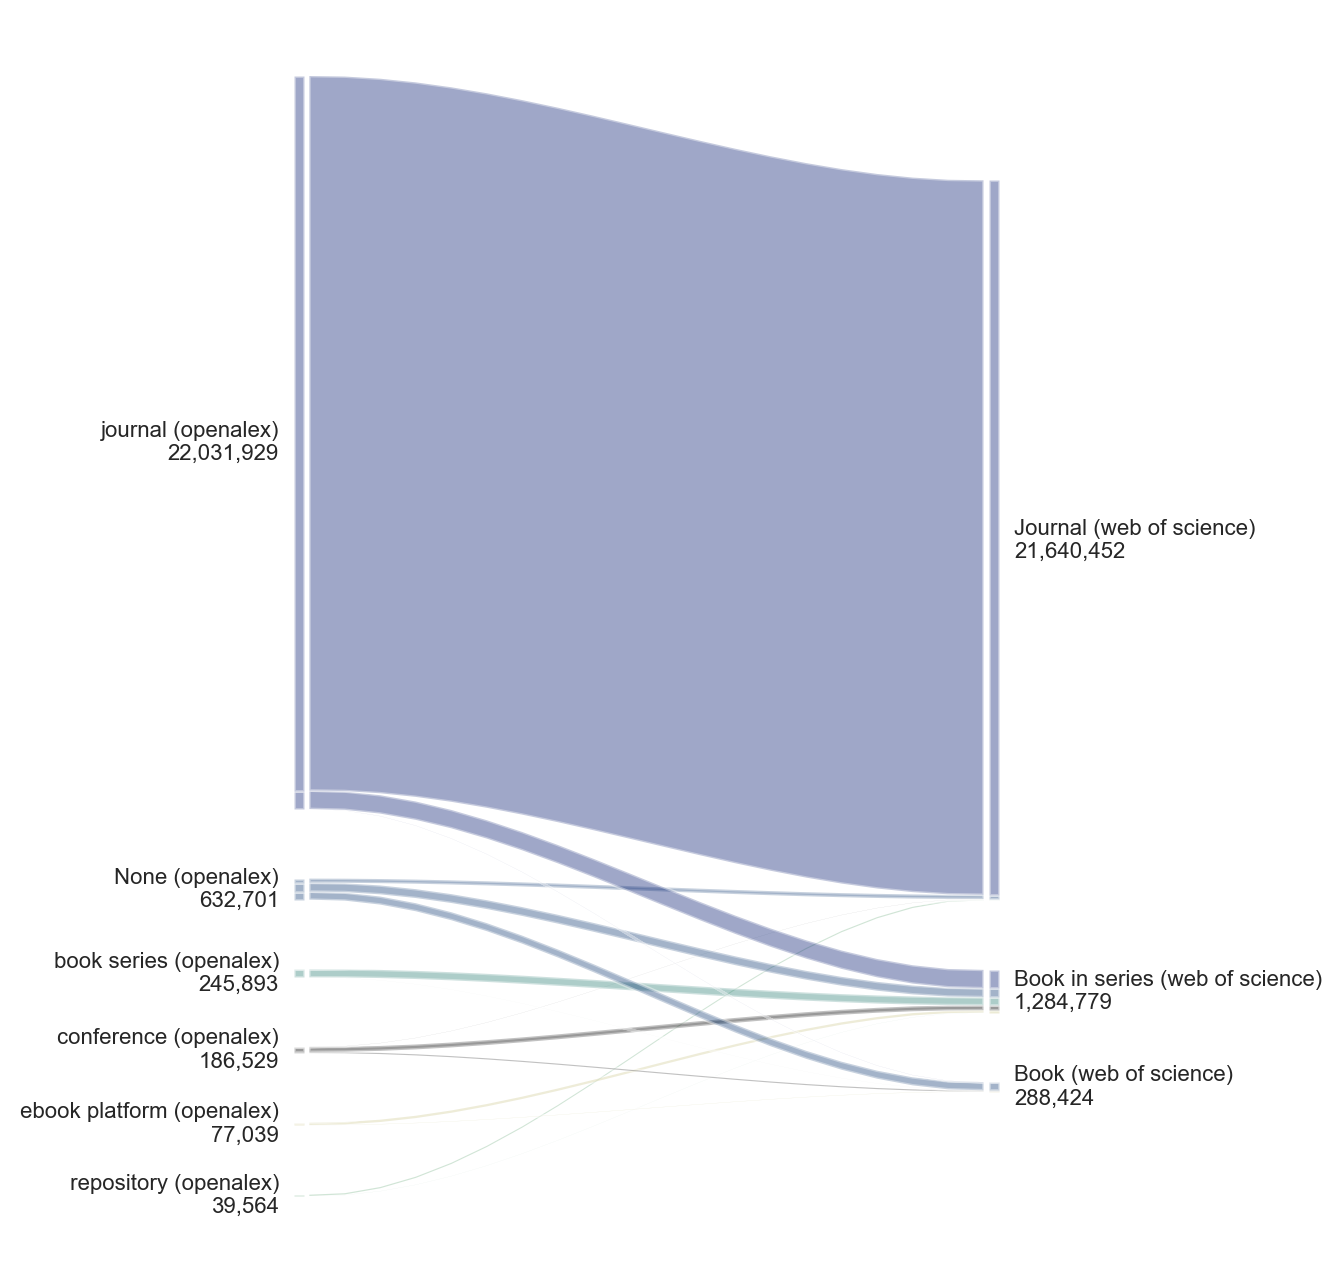

In [19]:
alluvial_plot(oal_wos_venue, 'oal_venuetype', 'wos_venuetype', 'openalex', 'web of science', 'openalex_wos_venues', 5, 8)

In [13]:
s2_oal_venues = pd.read_sql("""
                            SELECT s2_venues.type AS s2_venuetype, 
                                   oal_sources.type AS oal_venuetype, 
                                   COUNT(DISTINCT(oal_works.doi)) AS n
                            FROM fiz_openalex_rep_20230819_openbib.works oal_works
                            LEFT JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                                ON oal_works.id = oal_primary.work_id
                            LEFT JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                                ON oal_primary.source_id = oal_sources.id
                            INNER JOIN open_add_ons.s2_2023_09_26_papers AS s2
                                ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(s2.externalids ->> 'DOI')
                            LEFT JOIN open_add_ons.s2_2023_09_26_venues AS s2_venues
                                ON s2.publicationvenueid = s2_venues.id
                            WHERE oal_works.publication_year BETWEEN 2012 AND 2022
                            GROUP BY s2_venuetype, oal_venuetype
                            ORDER BY s2_venuetype, oal_venuetype
                            """, 
                            con=engine)

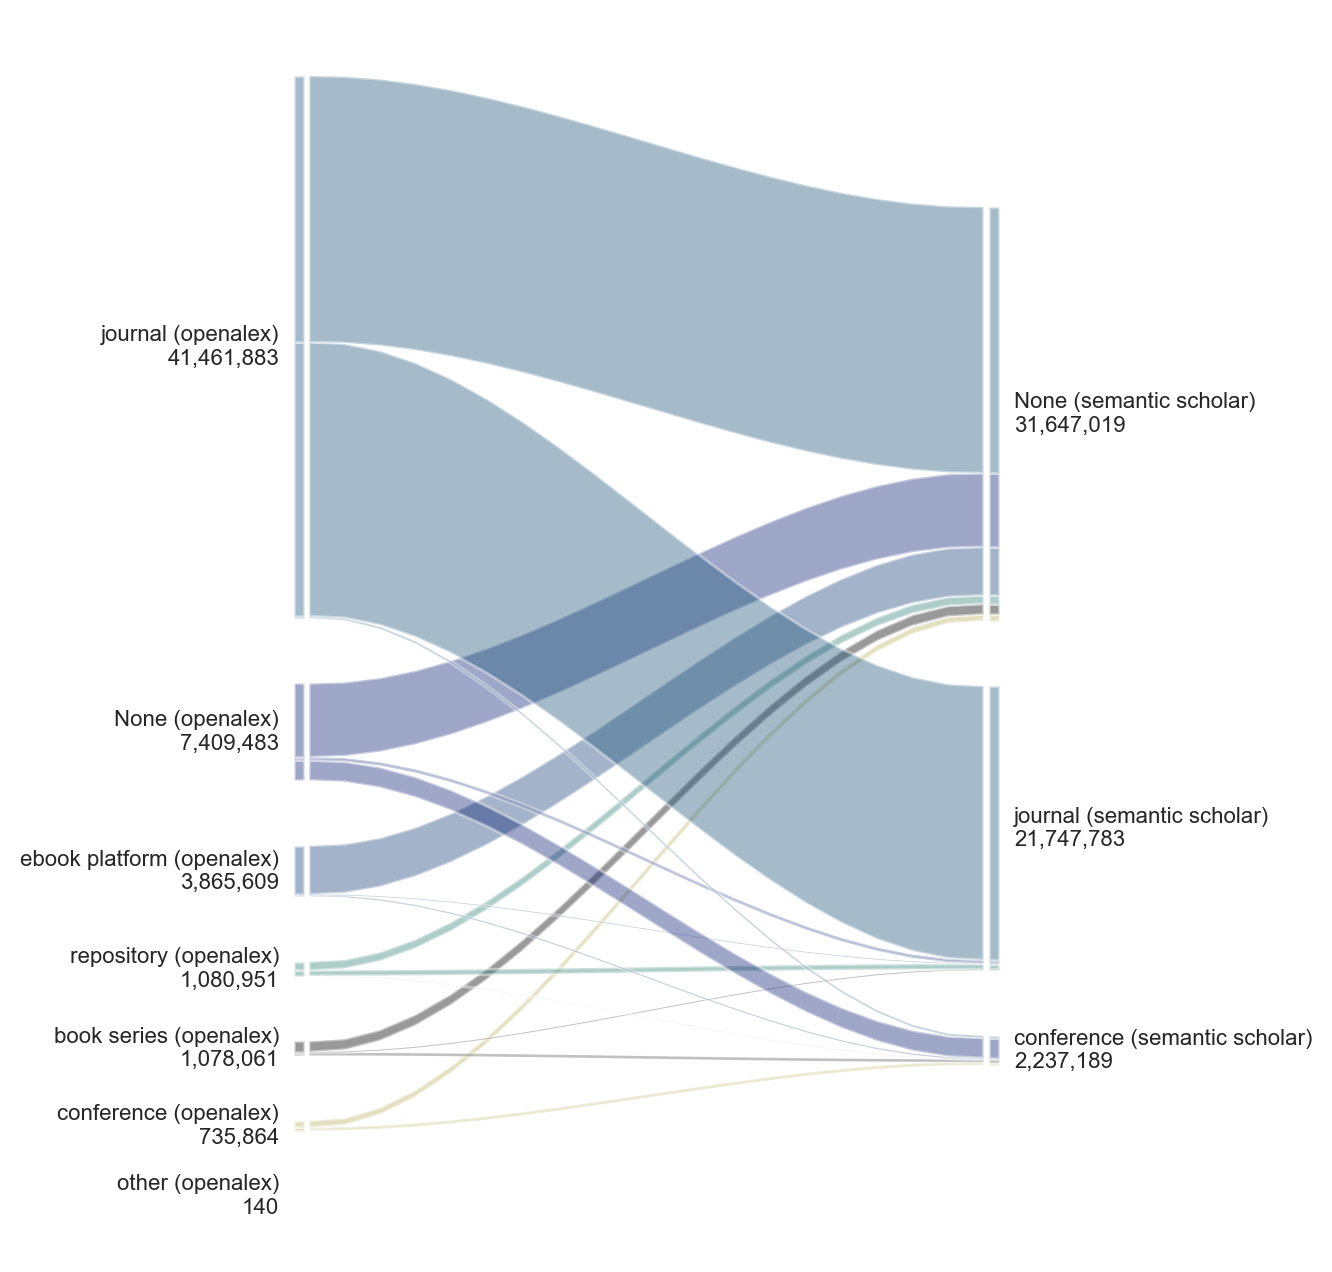

In [17]:
alluvial_plot(s2_oal_venues, 'oal_venuetype', 's2_venuetype', 'openalex', 'semantic scholar', 'openalex_s2_venues', 5, 8)

In [58]:
oal_venues = pd.read_sql("""
                         SELECT CASE
                                    WHEN oal_works.type = 'book-series' THEN 'book'
                                    WHEN oal_works.type = 'proceedings' THEN 'paratext' 
                                    WHEN oal_works.type = 'book-set' THEN 'book' 
                                    WHEN oal_works.type = 'book-part' THEN 'book-chapter'
                                    WHEN oal_works.type = 'posted-content' THEN 'article' 
                                    WHEN oal_works.type = 'proceedings-series' THEN 'paratext' 
                                    WHEN oal_works.type = 'proceedings-article' THEN 'article' 
                                    WHEN oal_works.type = 'journal-issue' THEN 'paratext' 
                                    WHEN oal_works.type = 'journal' THEN 'paratext'
                                    WHEN oal_works.type = 'monograph' THEN 'book'
                                    WHEN oal_works.type = 'journal-article' THEN 'article'
                                    WHEN oal_works.type = 'journal-volume' THEN 'paratext'
                                    ELSE oal_works.type
                                END AS oal_type, 
                                oal_sources.type AS oal_venuetype, COUNT(DISTINCT(oal_works.doi)) AS n
                         FROM fiz_openalex_rep_20230819_openbib.works oal_works
                         LEFT JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                             ON oal_works.id = oal_primary.work_id
                         LEFT JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                             ON oal_primary.source_id = oal_sources.id
                         WHERE oal_works.publication_year BETWEEN 2012 AND 2022
                         GROUP BY oal_venuetype, oal_type
                         ORDER BY oal_venuetype, oal_type
                         """, 
                         con=engine)

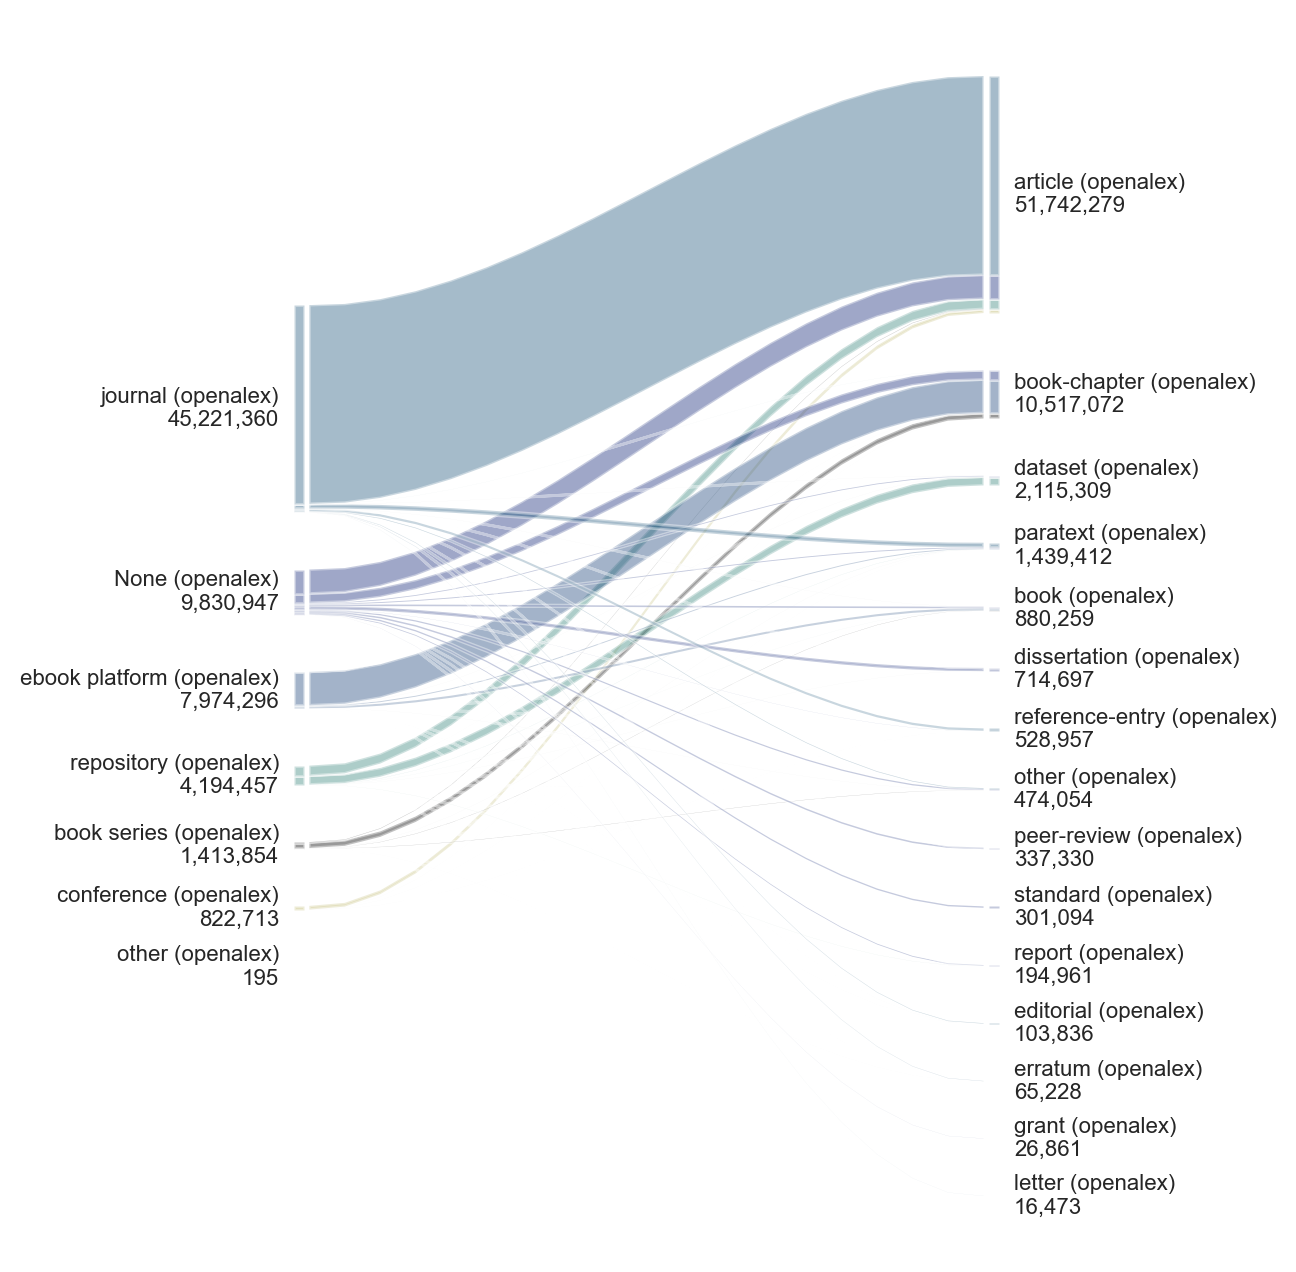

In [59]:
alluvial_plot(oal_venues, 'oal_venuetype', 'oal_type', 'openalex', 'openalex', 'oal_type_venue', 5, 8, 0.18)

In [20]:
oal_types = pd.read_sql("""
                        SELECT oal_type,
                               SUM(n) AS n 
                        FROM (
                            SELECT CASE
                                        WHEN oal_type = 'book-series' THEN 'book'
                                        WHEN oal_type = 'proceedings' THEN 'paratext' 
                                        WHEN oal_type = 'book-set' THEN 'book' 
                                        WHEN oal_type = 'posted-content' THEN 'article' 
                                        WHEN oal_type = 'proceedings-series' THEN 'paratext' 
                                        WHEN oal_type = 'proceedings-article' THEN 'article' 
                                        WHEN oal_type = 'journal-issue' THEN 'paratext' 
                                        WHEN oal_type = 'journal' THEN 'paratext'
                                        WHEN oal_type = 'monograph' THEN 'book'
                                        WHEN oal_type = 'journal-article' THEN 'article'
                                        WHEN oal_type = 'journal-volume' THEN 'paratext'
                                        ELSE oal_type
                                    END AS oal_type, 
                                    COUNT(DISTINCT(doi)) AS n
                            FROM unignhaupka.oal_wos_scp_s2_pubmed_comparison_2012_22
                            GROUP BY oal_type
                        ) t
                        GROUP BY oal_type
                        ORDER BY n DESC
                        """, 
                        con=engine)

In [21]:
oal_types['prop'] = (oal_types['n'] / oal_types['n'].sum()) * 100
oal_types

,oal_type,n,prop
0,article,9528567.0,99.508752
1,editorial,20316.0,0.212164
2,erratum,15201.0,0.158747
3,letter,9712.0,0.101424
4,other,654.0,0.006830
5,paratext,636.0,0.006642
6,reference-entry,520.0,0.005430
7,report,1.0,0.000010


In [22]:
scp_types = pd.read_sql("""
                        SELECT unnest(scp_type) AS scp_doctype,
                               COUNT(DISTINCT(doi)) AS n
                        FROM unignhaupka.oal_wos_scp_s2_pubmed_comparison_2012_22
                        GROUP BY scp_doctype
                        ORDER BY n DESC
                        """, 
                        con=engine)

In [23]:
scp_types.loc[scp_types.n < 53858, 'scp_doctype'] = 'Other'
scp_types = scp_types.groupby(['scp_doctype'])['n'].sum().reset_index()
scp_types.sort_values(by=['n'], ascending=False, ignore_index=True, inplace=True)
scp_types['prop'] = (scp_types['n'] / scp_types['n'].sum()) * 100
scp_types

,scp_doctype,n,prop
0,Article,7618472,79.508518
1,Review,923486,9.637760
2,Letter,358420,3.740572
3,Note,251305,2.622690
4,Editorial,217034,2.265028
5,Erratum,99979,1.043409
6,Other,59403,0.619946
7,Conference Paper,53858,0.562077


In [24]:
wos_types = pd.read_sql("""
                        SELECT unnest(wos_type) AS wos_doctype,
                               COUNT(DISTINCT(doi)) AS n
                        FROM unignhaupka.oal_wos_scp_s2_pubmed_comparison_2012_22
                        GROUP BY wos_doctype
                        ORDER BY n DESC
                        """, 
                        con=engine)

In [25]:
wos_types.loc[wos_types.n < 37479, 'wos_doctype'] = 'Other'
wos_types = wos_types.groupby(['wos_doctype'])['n'].sum().reset_index()
wos_types.sort_values(by=['n'], ascending=False, ignore_index=True, inplace=True)
wos_types['prop'] = (wos_types['n'] / wos_types['n'].sum()) * 100
wos_types

,wos_doctype,n,prop
0,Article,7535712,77.771425
1,Review,878361,9.065021
2,Editorial Material,637569,6.579956
3,Letter,375866,3.879081
4,Correction,93702,0.967040
5,Proceedings Paper,70846,0.731158
6,Other,60029,0.619522
7,News Item,37479,0.386798


In [24]:
s2_types = pd.read_sql("""
                       SELECT s2_doctype,
                              COUNT(DISTINCT(doi)) AS n
                       FROM unignhaupka.oal_wos_scp_s2_pubmed_comparison_2012_22, json_array_elements_text(s2_type) AS s2_doctype
                       GROUP BY s2_doctype
                       ORDER BY n DESC
                       """, 
                       con=engine)

In [25]:
s2_types.loc[s2_types.n < 71035, 's2_doctype'] = 'Other'
s2_types = s2_types.groupby(['s2_doctype'])['n'].sum().reset_index()
s2_types.sort_values(by=['n'], ascending=False, ignore_index=True, inplace=True)
s2_types['prop'] = (s2_types['n'] / s2_types['n'].sum()) * 100
s2_types

,s2_doctype,n,prop
0,JournalArticle,8836640,72.954337
1,Review,1765638,14.576915
2,LettersAndComments,455431,3.759989
3,Study,410735,3.390983
4,CaseReport,263532,2.175691
5,Editorial,215889,1.782356
6,Other,93663,0.773272
7,ClinicalTrial,71035,0.586457


In [26]:
pm_types = pd.read_sql("""
                       SELECT pm_grouptype,
                              COUNT(DISTINCT(doi)) AS n
                       FROM unignhaupka.oal_wos_scp_s2_pubmed_comparison_2012_22
                       GROUP BY pm_grouptype
                       ORDER BY n DESC
                       """, 
                       con=engine)

In [27]:
pm_types.loc[pm_types.n < 198037, 'pm_grouptype'] = 'Other'
pm_types = pm_types.groupby(['pm_grouptype'])['n'].sum().reset_index()
pm_types.sort_values(by=['n'], ascending=False, ignore_index=True, inplace=True)
pm_types['prop'] = (pm_types['n'] / pm_types['n'].sum()) * 100
pm_types

,pm_grouptype,n,prop
0,Journal_Article,7178813,74.963603
1,Review,880030,9.189572
2,Letter,352031,3.676027
3,RCT,293069,3.060326
4,Case_Reports,279377,2.917350
5,Editorial,229707,2.398679
6,SR_and_MA,198037,2.067970
7,Other,165334,1.726474


In [14]:
oal_types_new = pd.read_sql("""
                            SELECT oal_type,
                                   SUM(n) AS n 
                            FROM (
                                SELECT CASE
                                            WHEN oal_type = 'book-series' THEN 'book'
                                            WHEN oal_type = 'proceedings' THEN 'paratext' 
                                            WHEN oal_type = 'book-set' THEN 'book' 
                                            WHEN oal_type = 'posted-content' THEN 'article' 
                                            WHEN oal_type = 'proceedings-series' THEN 'paratext' 
                                            WHEN oal_type = 'proceedings-article' THEN 'article' 
                                            WHEN oal_type = 'journal-issue' THEN 'paratext' 
                                            WHEN oal_type = 'journal' THEN 'paratext'
                                            WHEN oal_type = 'monograph' THEN 'book'
                                            WHEN oal_type = 'journal-article' THEN 'article'
                                            WHEN oal_type = 'journal-volume' THEN 'paratext'
                                            ELSE oal_type
                                        END AS oal_type, 
                                        COUNT(DISTINCT(doi)) AS n
                                FROM unignhaupka.oal_wos_scp_s2_pubmed_comparison_2012_22
                                GROUP BY oal_type
                            ) t
                            GROUP BY oal_type
                            ORDER BY n DESC
                            """, 
                            con=engine)

In [15]:
oal_types_new['oal_new_type'] = oal_types_new.apply(lambda row : mapping_types(openalex_type_mapping['journal'], row['oal_type']), axis=1)
oal_types_new = oal_types_new.groupby(['oal_new_type'])['n'].sum().reset_index()
oal_types_new['prop'] = (oal_types_new['n'] / oal_types_new['n'].sum()) * 100
oal_types_new

,oal_new_type,n,prop
0,editorial_discourse,45865.0,0.478977
1,others,1175.0,0.012271
2,research_discourse,9528567.0,99.508752


In [28]:
scp_types_new = pd.read_sql("""
                            SELECT unnest(scp_type) AS scp_doctype,
                                   COUNT(DISTINCT(doi)) AS n
                            FROM unignhaupka.oal_wos_scp_s2_pubmed_comparison_2012_22
                            GROUP BY scp_doctype
                            ORDER BY n DESC
                            """, 
                            con=engine)

In [29]:
scp_types_new['scp_new_type'] = scp_types_new.apply(lambda row : mapping_types(scp_type_mapping['journal'], row['scp_doctype']), axis=1)
scp_types_new = scp_types_new.groupby(['scp_new_type'])['n'].sum().reset_index()
scp_types_new['prop'] = (scp_types_new['n'] / scp_types_new['n'].sum()) * 100
scp_types_new

,scp_new_type,n,prop
0,editorial_discourse,926738,9.671699
1,others,113261,1.182024
2,research_discourse,8541958,89.146278


In [30]:
wos_types_new = pd.read_sql("""
                            SELECT unnest(wos_type) AS wos_doctype,
                                   COUNT(DISTINCT(doi)) AS n
                            FROM unignhaupka.oal_wos_scp_s2_pubmed_comparison_2012_22
                            GROUP BY wos_doctype
                            ORDER BY n DESC
                            """, 
                            con=engine)

In [31]:
wos_types_new['wos_new_type'] = wos_types_new.apply(lambda row : mapping_types(wos_type_mapping['journal'], row['wos_doctype']), axis=1)
wos_types_new = wos_types_new.groupby(['wos_new_type'])['n'].sum().reset_index()
wos_types_new['prop'] = (wos_types_new['n'] / wos_types_new['n'].sum()) * 100
wos_types_new

,wos_new_type,n,prop
0,editorial_discourse,1153900,11.908689
1,others,121591,1.254866
2,research_discourse,8414073,86.836446


In [50]:
s2_types_new = pd.read_sql("""
                           SELECT s2_doctype,
                                  COUNT(DISTINCT(doi)) AS n
                           FROM unignhaupka.oal_wos_scp_s2_pubmed_comparison_2012_22, json_array_elements_text(s2_type) AS s2_doctype
                           GROUP BY s2_doctype
                           ORDER BY n DESC
                           """, 
                           con=engine)

In [51]:
s2_types_new['s2_new_type'] = s2_types_new.apply(lambda row : mapping_types(s2_type_mapping['journal'], row['s2_doctype']), axis=1)
s2_types_new = s2_types_new.groupby(['s2_new_type'])['n'].sum().reset_index()
s2_types_new['prop'] = (s2_types_new['n'] / s2_types_new['n'].sum()) * 100
s2_types_new

,s2_new_type,n,prop
0,editorial_discourse,703573,5.808622
1,others,649,0.005358
2,research_discourse,11408341,94.186020


In [32]:
pm_types_new = pd.read_sql("""
                           SELECT pm_type,
                                  COUNT(DISTINCT(doi)) AS n
                           FROM unignhaupka.oal_wos_scp_s2_pubmed_comparison_2012_22
                           GROUP BY pm_type
                           ORDER BY n DESC
                           """, 
                           con=engine)

In [33]:
pm_types_new['pm_new_type'] = pm_types_new.apply(lambda row : mapping_types(pubmed_type_mapping['journal'], row['pm_type']), axis=1)
pm_types_new = pm_types_new.groupby(['pm_new_type'])['n'].sum().reset_index()
pm_types_new['prop'] = (pm_types_new['n'] / pm_types_new['n'].sum()) * 100
pm_types_new

,pm_new_type,n,prop
0,editorial_discourse,985505,7.682565
1,others,479936,3.741371
2,research_discourse,11362371,88.576064


In [76]:
oal_pt_typol = pd.read_sql("""
                           SELECT COUNT(DISTINCT(oal_sources.type)) AS n
                           FROM fiz_openalex_rep_20230819_openbib.works oal_works
                           LEFT JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                               ON oal_works.id = oal_primary.work_id
                           LEFT JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                               ON oal_primary.source_id = oal_sources.id
                           WHERE oal_sources.type IS NOT NULL AND oal_works.publication_year BETWEEN 2012 AND 2022
                           """, 
                           con=engine)

In [77]:
oal_pt_typol

,n
0,6


In [41]:
oal_pt_typol_n = pd.read_sql("""
                             SELECT COUNT(DISTINCT(doi)) AS n
                             FROM fiz_openalex_rep_20230819_openbib.works oal_works
                             LEFT JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                                 ON oal_works.id = oal_primary.work_id
                             LEFT JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                                 ON oal_primary.source_id = oal_sources.id
                             WHERE oal_sources.type IS NOT NULL AND oal_works.publication_year BETWEEN 2012 AND 2022
                             """, 
                             con=engine)

In [42]:
oal_pt_typol_n

,n
0,59625325


In [74]:
oal_dt_typol = pd.read_sql("""
                           SELECT COUNT(DISTINCT(oal_type))
                           FROM (
                                SELECT CASE
                                            WHEN type = 'book-series' THEN 'book'
                                            WHEN type = 'proceedings' THEN 'paratext' 
                                            WHEN type = 'book-set' THEN 'book' 
                                            WHEN type = 'posted-content' THEN 'article' 
                                            WHEN type = 'proceedings-series' THEN 'paratext' 
                                            WHEN type = 'proceedings-article' THEN 'article' 
                                            WHEN type = 'journal-issue' THEN 'paratext' 
                                            WHEN type = 'journal' THEN 'paratext'
                                            WHEN type = 'monograph' THEN 'book'
                                            WHEN type = 'journal-article' THEN 'article'
                                            WHEN type = 'journal-volume' THEN 'paratext'
                                            ELSE type
                                        END AS oal_type
                                FROM fiz_openalex_rep_20230819_openbib.works oal_works
                                WHERE oal_works.type IS NOT NULL AND oal_works.publication_year BETWEEN 2012 AND 2022
                           ) t
                           """, 
                           con=engine)

In [75]:
oal_dt_typol

,count
0,16


In [23]:
oal_dt_typol_n = pd.read_sql("""
                             SELECT COUNT(DISTINCT(doi)) AS n
                             FROM fiz_openalex_rep_20230819_openbib.works oal_works
                             WHERE oal_works.type IS NOT NULL AND oal_works.publication_year BETWEEN 2012 AND 2022
                             """, 
                             con=engine)

In [24]:
oal_dt_typol_n

,n
0,69456021


In [72]:
scp_pt_typol = pd.read_sql("""
                           SELECT COUNT(DISTINCT(scp_items.source_type)) AS n
                           FROM scp_b_202307.items scp_items
                           WHERE scp_items.source_type IS NOT NULL AND scp_items.pubyear BETWEEN 2012 AND 2022
                           """, 
                           con=engine)

In [73]:
scp_pt_typol

,n
0,7


In [39]:
scp_pt_typol_n = pd.read_sql("""
                             SELECT COUNT(DISTINCT(doi)) AS n
                             FROM scp_b_202307.items scp_items
                             WHERE scp_items.source_type IS NOT NULL AND scp_items.pubyear BETWEEN 2012 AND 2022
                             """, 
                             con=engine)

In [40]:
scp_pt_typol_n

,n
0,31914334


In [70]:
scp_dt_typol = pd.read_sql("""
                           SELECT COUNT(DISTINCT(item_type)) AS n
                           FROM scp_b_202307.items scp_items
                           WHERE item_type IS NOT NULL AND scp_items.pubyear BETWEEN 2012 AND 2022
                           """, 
                           con=engine)

In [71]:
scp_dt_typol

,n
0,18


In [35]:
scp_dt_typol_n = pd.read_sql("""
                           SELECT COUNT(DISTINCT(doi)) AS n
                           FROM scp_b_202307.items scp_items
                           WHERE item_type IS NOT NULL AND scp_items.pubyear BETWEEN 2012 AND 2022
                           """, 
                           con=engine)

In [36]:
scp_dt_typol_n

,n
0,31922514


In [68]:
wos_pt_typol = pd.read_sql("""
                           SELECT COUNT(DISTINCT(wos_items.source_type)) AS n
                           FROM wos_b_202307.v_items wos_items
                           WHERE wos_items.source_type IS NOT NULL AND wos_items.pubyear BETWEEN 2012 AND 2022
                           """, 
                           con=engine)

In [69]:
wos_pt_typol

,n
0,3


In [27]:
wos_pt_typol_n = pd.read_sql("""
                             SELECT COUNT(DISTINCT(doi)) AS n
                             FROM wos_b_202307.v_items wos_items
                             WHERE wos_items.source_type IS NOT NULL AND wos_items.pubyear BETWEEN 2012 AND 2022
                             """, 
                             con=engine)

In [28]:
wos_pt_typol_n

,n
0,23540852


In [66]:
wos_dt_typol = pd.read_sql("""
                           SELECT COUNT(DISTINCT(item_type)) AS n
                           FROM wos_b_202307.v_items wos_items
                           WHERE item_type IS NOT NULL AND wos_items.pubyear BETWEEN 2012 AND 2022
                           """, 
                           con=engine)

In [67]:
wos_dt_typol

,n
0,87


In [31]:
wos_dt_typol_n = pd.read_sql("""
                           SELECT COUNT(DISTINCT(doi)) AS n
                           FROM wos_b_202307.v_items wos_items
                           WHERE item_type IS NOT NULL AND wos_items.pubyear BETWEEN 2012 AND 2022
                           """, 
                           con=engine)

In [32]:
wos_dt_typol_n

,n
0,23540852


In [64]:
s2_pt_typol = pd.read_sql("""
                          SELECT COUNT(DISTINCT(s2_venues.type)) AS n
                          FROM unignhaupka.s2_2023_09_26_papers_2000 as s2_items
                          LEFT JOIN unignhaupka.s2_2023_09_26_venues AS s2_venues
                              ON s2_items.publicationvenueid = s2_venues.id
                          WHERE s2_venues.type IS NOT NULL AND s2_items.year BETWEEN 2012 AND 2022
                          """, 
                          con=engine)

In [65]:
s2_pt_typol

,n
0,2


In [54]:
s2_pt_typol_n = pd.read_sql("""
                            SELECT COUNT(DISTINCT(doi)) AS n
                            FROM unignhaupka.s2_2023_09_26_papers_2000 as s2_items
                            LEFT JOIN unignhaupka.s2_2023_09_26_venues AS s2_venues
                                ON s2_items.publicationvenueid = s2_venues.id
                            WHERE s2_venues.type IS NOT NULL AND s2_items.year BETWEEN 2012 AND 2022
                            """, 
                            con=engine)

In [55]:
s2_pt_typol_n

,n
0,24537185


In [60]:
s2_dt_typol = pd.read_sql("""
                          SELECT COUNT(DISTINCT(s2_doctype)) AS n
                          FROM unignhaupka.s2_2023_09_26_papers_2000 as s2_items, json_array_elements_text(publicationtypes) AS s2_doctype
                          WHERE s2_doctype IS NOT NULL AND s2_items.year BETWEEN 2012 AND 2022
                          """, 
                          con=engine)

In [61]:
s2_dt_typol

,n
0,12


In [46]:
s2_dt_typol_n = pd.read_sql("""
                            SELECT COUNT(DISTINCT(s2_items.doi)) AS n
                            FROM unignhaupka.s2_2023_09_26_papers_2000 as s2_items
                            WHERE JSON_ARRAY_LENGTH(publicationtypes) != 0 AND s2_items.year BETWEEN 2012 AND 2022
                            """, 
                            con=engine)

In [47]:
s2_dt_typol_n

,n
0,20845208


In [62]:
pm_dt_typol = pd.read_sql("""
                          SELECT COUNT(DISTINCT(pm_type.ptype)) AS n
                          FROM dzhwaschniedermann.ac24_import_fromlocal AS pm_items
                          INNER JOIN dzhwaschniedermann.ac24_ptype_hierarchy as pm_type
            				  ON pm_items.ptyperank = pm_type.grouprank
                          WHERE pm_type.ptype IS NOT NULL AND pubmed_date >= to_date('2012', 'YYYY') AND pubmed_date < to_date('2023', 'YYYY')
                          """, 
                          con=engine)

In [63]:
pm_dt_typol

,n
0,79


In [58]:
pm_dt_typol = pd.read_sql("""
                          SELECT COUNT(DISTINCT(pm_items.doi)) AS n
                          FROM dzhwaschniedermann.ac24_import_fromlocal AS pm_items
                          INNER JOIN dzhwaschniedermann.ac24_ptype_hierarchy as pm_type
                			  ON pm_items.ptyperank = pm_type.grouprank
                          WHERE pm_type.ptype IS NOT NULL AND pubmed_date >= to_date('2012', 'YYYY') AND pubmed_date < to_date('2023', 'YYYY')
                          """, 
                          con=engine)

In [59]:
pm_dt_typol

,n
0,12681217


In [13]:
oal_types_re = pd.read_sql("""
                            SELECT oal_type,
                                   SUM(n) AS n 
                            FROM (
                                SELECT CASE
                                            WHEN type = 'book-series' THEN 'book'
                                            WHEN type = 'proceedings' THEN 'paratext' 
                                            WHEN type = 'book-set' THEN 'book' 
                                            WHEN type = 'posted-content' THEN 'article' 
                                            WHEN type = 'proceedings-series' THEN 'paratext' 
                                            WHEN type = 'proceedings-article' THEN 'article' 
                                            WHEN type = 'journal-issue' THEN 'paratext' 
                                            WHEN type = 'journal' THEN 'paratext'
                                            WHEN type = 'monograph' THEN 'book'
                                            WHEN type = 'journal-article' THEN 'article'
                                            WHEN type = 'journal-volume' THEN 'paratext'
                                            WHEN is_paratext = True THEN 'paratext'
                                            WHEN is_retracted = True THEN 'retraction'
                                            ELSE type
                                        END AS oal_type, 
                                        COUNT(DISTINCT(doi)) AS n
                                FROM fiz_openalex_rep_20230819_openbib.works oal_works
                                WHERE oal_works.publication_year BETWEEN 2012 AND 2022
                                GROUP BY oal_type
                            ) t
                            GROUP BY oal_type
                            ORDER BY n DESC
                            """, 
                            con=engine)

In [14]:
oal_types_re['prop'] = (oal_types_re['n'] / oal_types_re['n'].sum()) * 100
oal_types_re

,oal_type,n,prop
0,article,51729932.0,74.478621
1,book-chapter,10501599.0,15.119769
2,dataset,2115309.0,3.045535
3,paratext,1439441.0,2.072448
4,book,880245.0,1.267340
5,dissertation,714665.0,1.028945
6,reference-entry,528947.0,0.761556
7,other,473985.0,0.682424
8,peer-review,337330.0,0.485674
9,standard,301094.0,0.433503


In [15]:
oal_types_re = pd.read_sql("""
                            SELECT oal_type,
                                   SUM(n) AS n 
                            FROM (
                                SELECT CASE
                                            WHEN type = 'book-series' THEN 'book'
                                            WHEN type = 'proceedings' THEN 'paratext' 
                                            WHEN type = 'book-set' THEN 'book' 
                                            WHEN type = 'posted-content' THEN 'article' 
                                            WHEN type = 'proceedings-series' THEN 'paratext' 
                                            WHEN type = 'proceedings-article' THEN 'article' 
                                            WHEN type = 'journal-issue' THEN 'paratext' 
                                            WHEN type = 'journal' THEN 'paratext'
                                            WHEN type = 'monograph' THEN 'book'
                                            WHEN type = 'journal-article' THEN 'article'
                                            WHEN type = 'journal-volume' THEN 'paratext'
                                            ELSE type
                                        END AS oal_type, 
                                        COUNT(DISTINCT(doi)) AS n
                                FROM fiz_openalex_rep_20230819_openbib.works oal_works
                                WHERE oal_works.publication_year BETWEEN 2012 AND 2022
                                GROUP BY oal_type
                            ) t
                            GROUP BY oal_type
                            ORDER BY n DESC
                            """, 
                            con=engine)

In [16]:
oal_types_re['prop'] = (oal_types_re['n'] / oal_types_re['n'].sum()) * 100
oal_types_re

,oal_type,n,prop
0,article,51740675.0,74.494091
1,book-chapter,10501738.0,15.119970
2,dataset,2115309.0,3.045535
3,paratext,1439376.0,2.072354
4,book,880245.0,1.267340
5,dissertation,714665.0,1.028945
6,reference-entry,528947.0,0.761556
7,other,474053.0,0.682522
8,peer-review,337330.0,0.485674
9,standard,301094.0,0.433503


In [15]:
oal_scp_type = pd.read_sql("""
                         SELECT oal_type AS oaltype, unnest(scp_type) AS scptype, COUNT(DISTINCT(doi)) AS n
                         FROM unignhaupka.oal_wos_scp_s2_pubmed_comparison_2012_22
                         GROUP BY oaltype, scptype
                         """, 
                         con=engine)

In [53]:
oal_scp_type.loc[(oal_scp_type.scptype == 'Abstract Report'), 'scptype'] = 'Other'
oal_scp_type.loc[(oal_scp_type.scptype == 'Business Article'), 'scptype'] = 'Other'
oal_scp_type.loc[(oal_scp_type.scptype == 'Article in Press'), 'scptype'] = 'Other'

oal_scp_type = oal_scp_type.groupby(['oaltype', 'scptype'])['n'].sum().reset_index()

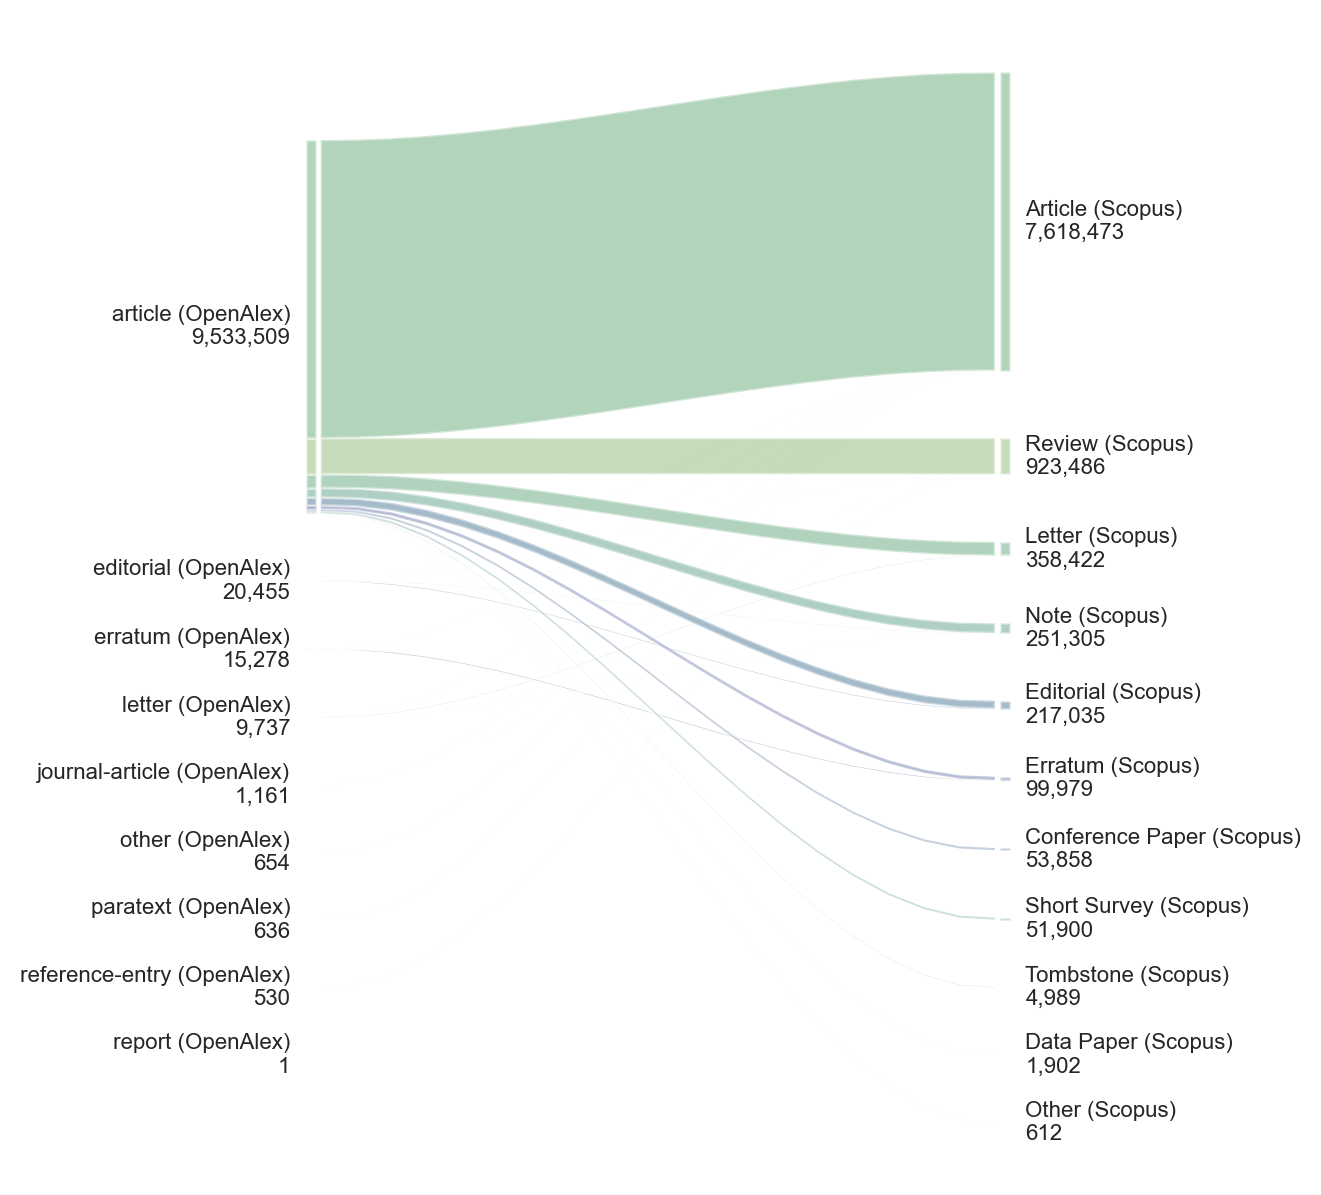

In [54]:
alluvial_plot(oal_scp_type, 'oaltype', 'scptype', 'OpenAlex', 'Scopus', 'oal_scp_type', 5, 7.5, 0.18)

In [19]:
oal_wos_type = pd.read_sql("""
                           SELECT oal_type AS oaltype, unnest(wos_type) AS wostype, COUNT(DISTINCT(doi)) AS n
                           FROM unignhaupka.oal_wos_scp_s2_pubmed_comparison_2012_22
                           GROUP BY oaltype, wostype
                           """, 
                           con=engine)

In [48]:
oal_wos_type.loc[(oal_wos_type.wostype == 'Retracted Publication'), 'wostype'] = 'Other'
oal_wos_type.loc[(oal_wos_type.wostype == 'Data Paper'), 'wostype'] = 'Other'
oal_wos_type.loc[(oal_wos_type.wostype == 'Meeting Abstract'), 'wostype'] = 'Other'
oal_wos_type.loc[(oal_wos_type.wostype == 'Book Review'), 'wostype'] = 'Other'
oal_wos_type.loc[(oal_wos_type.wostype == 'Reprint'), 'wostype'] = 'Other'
oal_wos_type.loc[(oal_wos_type.wostype == 'Expression of Concern'), 'wostype'] = 'Other'
oal_wos_type.loc[(oal_wos_type.wostype == 'CC Meeting Heading'), 'wostype'] = 'Other'
oal_wos_type.loc[(oal_wos_type.wostype == 'Book Chapter'), 'wostype'] = 'Other'
oal_wos_type.loc[(oal_wos_type.wostype == 'Item Withdrawal'), 'wostype'] = 'Other'
oal_wos_type.loc[(oal_wos_type.wostype == 'Poetry'), 'wostype'] = 'Other'
oal_wos_type.loc[(oal_wos_type.wostype == 'Bibliography'), 'wostype'] = 'Other'
oal_wos_type.loc[(oal_wos_type.wostype == 'Software Review'), 'wostype'] = 'Other'
oal_wos_type.loc[(oal_wos_type.wostype == 'Hardware Review'), 'wostype'] = 'Other'
oal_wos_type.loc[(oal_wos_type.wostype == 'Film Review'), 'wostype'] = 'Other'
oal_wos_type.loc[(oal_wos_type.wostype == 'Theater Review'), 'wostype'] = 'Other'
oal_wos_type.loc[(oal_wos_type.wostype == 'Database Review'), 'wostype'] = 'Other'
oal_wos_type.loc[(oal_wos_type.wostype == 'Art Exhibit Review'), 'wostype'] = 'Other'
oal_wos_type.loc[(oal_wos_type.wostype == 'Record Review'), 'wostype'] = 'Other'
oal_wos_type.loc[(oal_wos_type.wostype == 'Dance Performance Review'), 'wostype'] = 'Other'

oal_wos_type = oal_wos_type.groupby(['oaltype', 'wostype'])['n'].sum().reset_index()

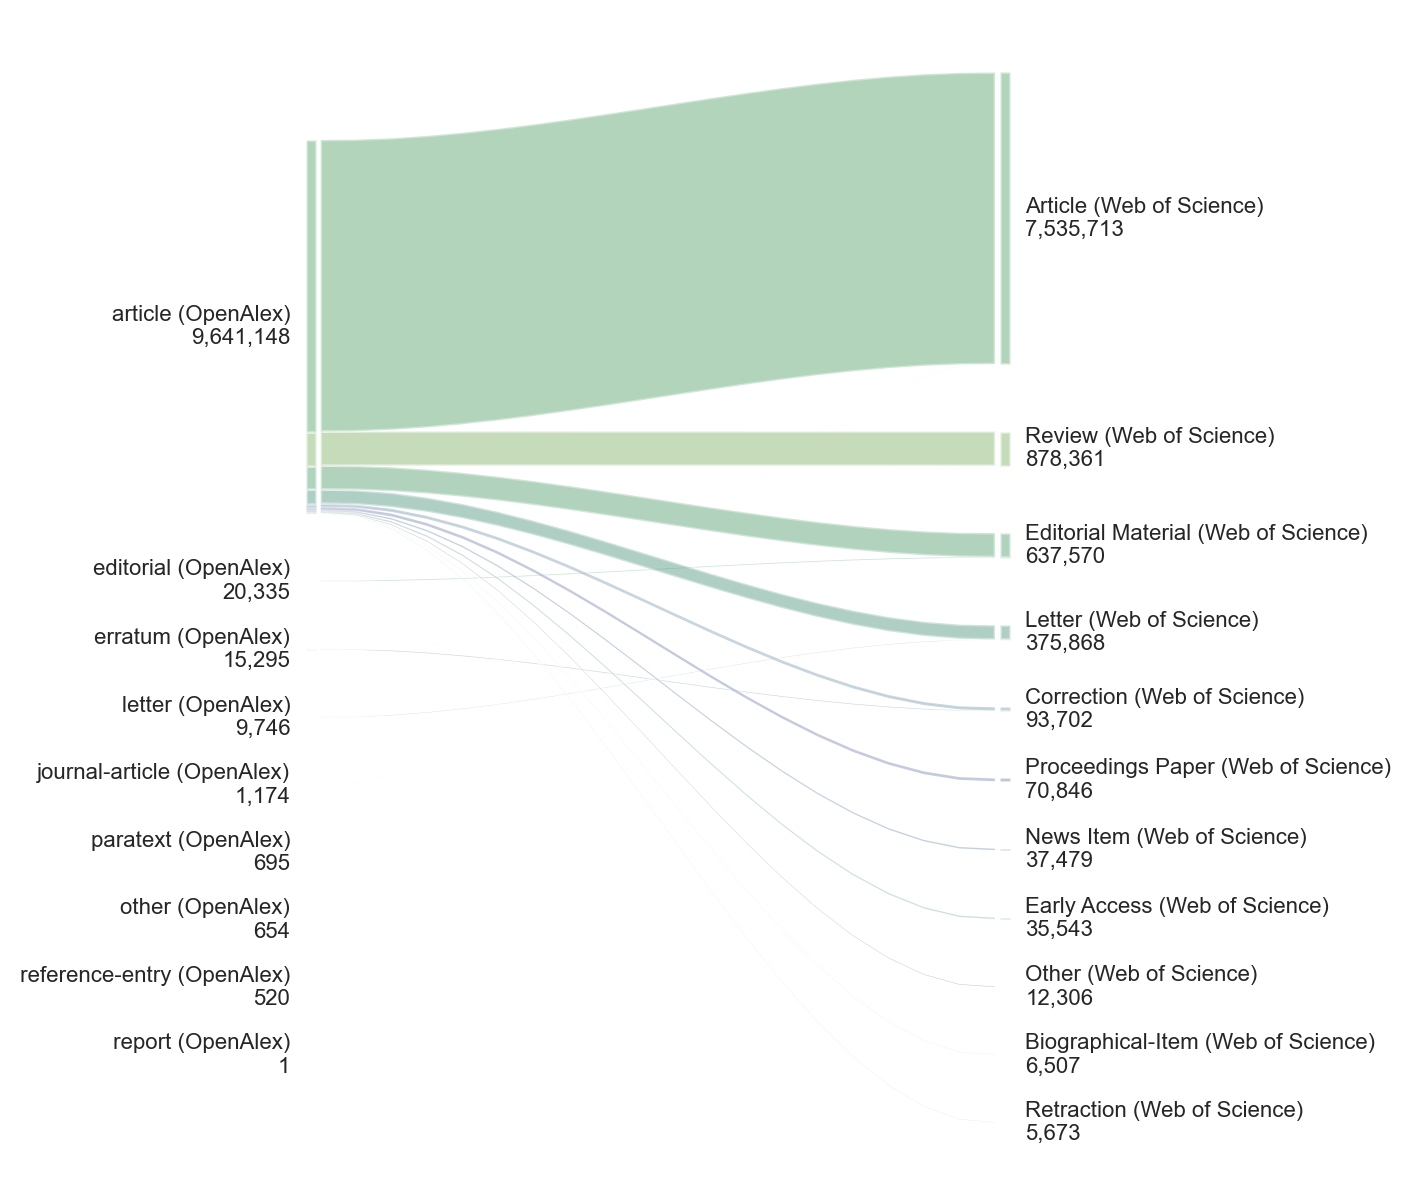

In [51]:
alluvial_plot(oal_wos_type, 'oaltype', 'wostype', 'OpenAlex', 'Web of Science', 'oal_wos_type', 5, 7.5, 0.18)